In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pylab
####################### Plotting tools
import matplotlib
import matplotlib.pyplot as plt
#import seaborn
####################### data frames
import pandas as pd
from pandas.tools import plotting
####################### Utilities
import urllib
from six.moves import cPickle as pickle
import random 
from csv import reader
from math import sqrt
from math import floor
import os
import numpy as np
import scipy.sparse as sps
from pandas import DataFrame
from IPython.display import display
######################## From scikit-learn
from sklearn import random_projection
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
######################## From home directory
from forest_class import forest
from generalTrees_class import flex_binary_trees, master_trees
from tree_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
######------ Utility functions
def cross_valid_split(n_data, n_folds):
    """
    Given size of the data and number of folds
    Returns n_folds disjoint sets of indices, where indices
    in each fold are chosen u.a.r. without replacement
    """
    data_ind = list(range(n_data))    
    folds = list()
    fold_size = floor(n_data/n_folds)
    for i in range(n_folds):
        if i < n_folds-1:
            fold = list()
            while len(fold) <= fold_size:
                index = random.randrange(len(data_ind))
                fold.append(data_ind.pop(index))
            folds.append(fold)
        else:
            ## assign all remaining data to the last fold
            folds.append(data_ind)
    return folds

def zero_one_loss(labels, predictions):
    correct = 0
    for i in range(len(labels)):
        if labels[i] == predictions[i]:
            correct += 1
    loss = (len(labels)-correct)/float(len(labels))
    return loss

def explained_var_loss(labels, predictions):
    #res_var = np.sum(np.array([diff**2 for diff in labels-predictions]))
    res_var = np.var(np.array(labels)-np.array(predictions))
    tot_var = np.var(np.array(labels))
    
    return 1-res_var/tot_var

def l2_loss(labels, predictions):
    loss = np.linalg.norm(np.array(labels)-np.array(predictions))
    return loss/(len(labels)**(1/2))

def csize_decrease_rate(data, tree):
    """
    This is an unsupervised evaluation, which tries to capture how fast
    the data size of a cell decreases after building a tree
    """
    diam_s,_,_ = data_diameter(data)
    diam_f = 0
    
    if hasattr(tree, 'slave_tree'):
        ## if this is a master tree
        for leaf in traverseLeaves_mtree(tree):
            diam, _, _ = data_diameter(leaf.slave_tree.data[leaf.slave_tree.data_ind, :])
            if diam > diam_f:
                diam_f = diam
            
    else:
        ## if this is normal binary tree
        for leaf in traverseLeaves(tree):
            diam, _, _ = data_diameter(leaf.data[leaf.data_ind,:])
            if diam > diam_f:
                diam_f = diam
        
    return (diam_s/diam_f)/getDepth(tree)
        

def cross_valid_eval(data, labels, n_folds, loss, algorithm, sklearn=False, need_ind=False, **kwargs):
    """
    Given data and labels, a loss function, and a method
    generate a list of cv-losses
    
    """
    ## generate random folds
    folds_ind = cross_valid_split(data.shape[0], n_folds)
    losses = list()
    for fold_ind in folds_ind:
        print("Evaluating the %d-th fold" %(len(losses)+1))
        test_ind = fold_ind
        folds_ind_ = list(folds_ind) # this ensures we are not modifying the original list!
        folds_ind_.remove(fold_ind)
        train_ind = [item for sublist in folds_ind_ for item in sublist] #flatten remaining index set
        ## Further divide the data into train and test
        data_tr = data[train_ind,:]
        labels_tr = labels[train_ind]
        data_tt = data[test_ind,:]
        labels_tt = labels[test_ind]
        # train the algorithm 
        if sklearn:
            alg = algorithm(**kwargs)
            alg.fit(data_tr, labels_tr)
        elif need_ind:
            data_ind = np.ones(data_tr.shape[0], dtype=bool)
            alg = algorithm(data_tr, data_indices=data_ind, labels=labels_tr, **kwargs) #init
            alg.train()
        else:
            # RF and master trees don't need to be given an index 
            alg = algorithm(data_tr, labels=labels_tr, **kwargs) #init
            alg.train()
        #c = print_mtree_leaves(alg) ## added should be removed
        #print("There are %d partitions" %c)
        
        # calculate loss on the current fold
        #dp = None
        #if isinstance(alg, DecisionTreeClassifier):
        #    dp = alg.decision_path(data_tr)
        losses.append(loss(labels_tt, alg.predict(data_tt)))
        #print(labels[0],alg.predict(data_tt)[0])
        del alg
    return losses                  

## Dataset I - MNIST


In [11]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

ind4 = mnist.target == 4
ind7 = mnist.target == 7

data0 = mnist.data[ind4]
data1 = mnist.data[ind7]
data_all = np.concatenate((data0,data1), axis=0)
labels_all = np.ones(data_all.shape[0])
labels_all[:data0.shape[0]] = 0
rind = np.random.permutation(len(labels_all))
data_all_perm = data_all[rind]
labels_all_perm = labels_all[rind]

print('In MNIST, there are %d (%d) data points with label 0 (1)'%(len(data0), len(data1)))


def maybe_pickle(dataname, data = None, force = False, verbose = True):
    """
    Process and pickle a dataset if not present
    """
    filename = dataname + '.pickle'
    if force or not os.path.exists(filename):
        # pickle the dataset
        print('Pickling data to file %s' % filename)
        try:
            with open(filename, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save to', filename, ':', e) 
    else:
        print('%s already present - Skipping pickling.' % filename)
        with open(filename, 'rb') as f:
            data = pickle.load(f)

    return data

#data_dict = maybe_pickle('sonar.all_data', {'data':data_all_perm, 'labels':labels_all_perm}) 

In MNIST, there are 6824 (7293) data points with label 0 (1)


In [12]:
data = data_all
labels = labels_all
data_tr = data[:12000,:]
labels_tr = labels[:12000]
data_tt = data[12000:,:]
labels_tt = labels[12000:]
print('In MNIST, there are %d train and %d test data' %(len(labels_tr), len(labels_tt)))

In MNIST, there are 12000 train and 2117 test data


In [14]:
### Base tree evaluations 
split_design = {'name':'cart'}
######## original Decision Tree (sparisty=1) ############
sparsity = 1
target_dim = [1, 10, 28, 40]  ## varies target dimension (i.e., "mtry" variable, default is 28 = sqrt(784)) 
stop_design={'name':'naive'}
scores_c1 = list()
scores_c1_test = list()
params_c1 = list()

##
for t_dim in target_dim:
    proj_design={'name':'projmat','params':{'name':'breiman','sparsity':sparsity,'target_dim':t_dim}}        
    kwargs = {'proj_design':proj_design, 'split_design':split_design, 'stop_design':stop_design}
    scores_c1.append(cross_valid_eval(data_tr, labels_tr, 5, zero_one_loss, flex_binary_trees, 
                                              need_ind=True, **kwargs))
    #scores_c1_test.append(cross_valid_eval(data_tt, labels_tt, 5, zero_one_loss, flex_binary_trees, 
    #                                          need_ind=True, **kwargs))
    params_c1.append([t_dim])
    
######## Decision Tree with fixed sparsity ############
sparsity = [1, 3, 5]
target_dim = 28  ## varies target dimension (i.e., "mtry" variable, default is 28 = sqrt(784)) 
stop_design={'name':'naive'}
scores_c2 = list()
scores_c2_test = list()
params_c2 = list()

##
for s in sparsity:
    proj_design={'name':'projmat','params':{'name':'breiman','sparsity':s,'target_dim':target_dim}}        
    kwargs = {'proj_design':proj_design, 'split_design':split_design, 'stop_design':stop_design}
    scores_c2.append(cross_valid_eval(data_tr, labels_tr, 5, zero_one_loss, flex_binary_trees, 
                                              need_ind=True, **kwargs))
    #scores_c2_test.append(cross_valid_eval(data_tt, labels_tt, 5, zero_one_loss, flex_binary_trees, 
    #                                          need_ind=True, **kwargs))
    params_c2.append([s])

######## original Random projection tree (target_dim=1) ############
target_dim = 1
stop_rule = 'cell_size'
scores_c3 = list()
scores_c3_test = list()
params_c3 = list()
##
split_design = {'name':'median_perturb'}
proj_design = {'name':'projmat','params':{'name':'dasgupta','target_dim':target_dim}}
stop_design = {'name':stop_rule}
if stop_rule == 'cell_size':
    ddiam, _, _ = data_diameter(data_tr)
    stop_design['params'] = {'diameter':ddiam, 'max_level':2*np.log(data_tr.shape[0])}
if split_design['name'] == 'median_perturb':
    ddiam,_,_ = data_diameter(data_tr)
    split_design['params'] = {'diameter':ddiam}
kwargs = {'proj_design':proj_design, 'split_design':split_design, 'stop_design':stop_design}
scores_c3.append(cross_valid_eval(data_tr, labels_tr, 5, zero_one_loss, flex_binary_trees, 
                                          need_ind=True, **kwargs))
#scores_c2_test.append(cross_valid_eval(data_tt, labels_tt, 5, zero_one_loss, flex_binary_trees, 
#                                          need_ind=True, **kwargs))

######## Random projection tree with CART split (target_dim=1) ############
target_dim = 1
stop_rule = 'cell_size'
scores_c4 = list()
scores_c4_test = list()
params_c4 = list()
##
split_design = {'name':'cart'}
proj_design = {'name':'projmat','params':{'name':'dasgupta','target_dim':target_dim}}
stop_design = {'name':stop_rule}
if stop_rule == 'cell_size':
    ddiam, _, _ = data_diameter(data_tr)
    stop_design['params'] = {'diameter':ddiam, 'max_level':2*np.log(data_tr.shape[0])}
if split_design['name'] == 'median_perturb':
    ddiam,_,_ = data_diameter(data_tr)
    split_design['params'] = {'diameter':ddiam}
kwargs = {'proj_design':proj_design, 'split_design':split_design, 'stop_design':stop_design}
scores_c4.append(cross_valid_eval(data_tr, labels_tr, 5, zero_one_loss, flex_binary_trees, 
                                          need_ind=True, **kwargs))


Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold


KeyboardInterrupt: 

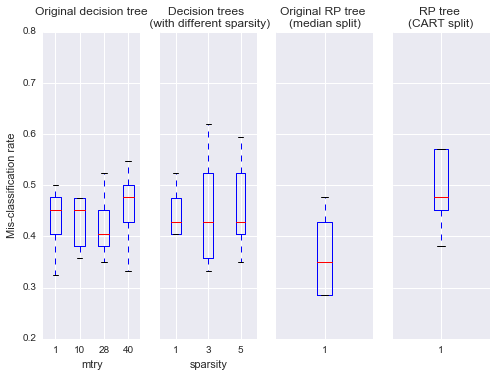

In [127]:
## Plotting
data = np.array(scores_c1).T
fig = plt.figure()
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
#ax1 = fig.add_subplot(121)
ax1.boxplot(data)
ax1.set_xlabel('mtry')
#ax1.set_xticks([1, 2, 3, 4], [1, 10, 28, 40])
ax1.set_ylabel('Mis-classification rate')
ax1.set_title("Original decision tree\n")
######
data = np.array(scores_c2).T
#ax2 = fig.add_subplot(122)
ax2.boxplot(data)
#ax2.set_xticks([1, 2, 3], [1, 3, 5])
ax2.set_xlabel('sparsity')
#ax2.set_ylabel('zero-one-loss')
ax2.set_title("Decision trees \n (with different sparsity)")
######
ax3.boxplot(scores_c3)
ax3.set_title('Original RP tree \n(median split)')
######
ax4.boxplot(scores_c4)
ax4.set_title('RP tree \n(CART split)')
#####
plt.sca(ax1)
plt.xticks([1, 2, 3, 4], [1, 10, 28, 40])
plt.sca(ax2)
plt.xticks([1, 2, 3], [1, 3, 5])
plt.show()




In [6]:
### Forest evaluations
n_trees_list = [10,50,100]
n_samples_list = [10, 50, 100]


################# Original RF
proj_design={'name':'projmat','params':{'name':'breiman','sparsity':1,'target_dim':28}}
split_design={'name':'cart'} 
stop_design = {'name':'naive'}
kwargs = {'tree_design':{"tree":'flex','proj_design':proj_design,'split_design':split_design,'stop_design':stop_design}, 
          'predictor_type':'class'}
scores_fc1 = list()
params_fc1 = list()
for n_trees in n_trees_list:
    for n_samples in n_samples_list:
        kwargs['n_trees'] = n_trees
        kwargs['n_samples'] = n_samples
        #kwargs['n_features'] = n_features
        scores_fc1.append(cross_valid_eval(data_tr, labels_tr, 5, zero_one_loss, forest, **kwargs))
        params_fc1.append([n_trees, n_samples])
        


Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold


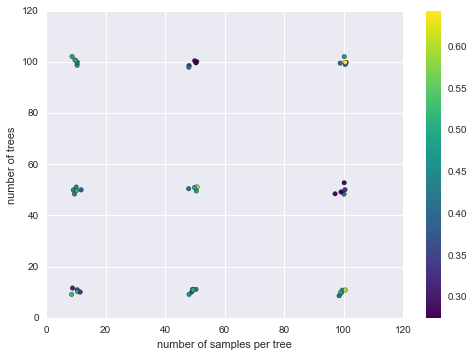

In [20]:
## Plotting for RF exp
n_trees_list = [10,50,100]
n_samples_list = [10, 50, 100]
n_folds = 5
x = np.zeros(len(n_trees_list)*len(n_samples_list)*n_folds)
y = np.zeros(len(n_trees_list)*len(n_samples_list)*n_folds)
val = np.zeros(len(n_trees_list)*len(n_samples_list)*n_folds)
t = 0
x_count = 0
y_count = 0
for nt in n_trees_list:
    for ns in n_samples_list:
        #print(y_count)
        for fold in range(n_folds):
            x[t] = nt + np.random.randn()
            y[t] = ns + np.random.randn()
            val[t] = scores_fc1[x_count+y_count][fold]
            t += 1
        y_count += 1
    y_count = 0
    x_count += 1
    #print(x_count)

plt.scatter(x, y, c=val, cmap='viridis')
plt.xlabel("number of samples per tree")
plt.ylabel("number of trees")
plt.colorbar()
plt.show()


In [34]:
### Forest evaluations II
n_trees_list = [10,50,100]
n_samples_list = [10, 50, 100]

################# RP-tree ensemble
target_dim = 1
stop_rule = 'cell_size'
##
split_design = {'name':'median_perturb'}
proj_design = {'name':'projmat','params':{'name':'dasgupta','target_dim':target_dim}}
stop_design = {'name':stop_rule}
if stop_rule == 'cell_size':
    ddiam, _, _ = data_diameter(data_tr)
    stop_design['params'] = {'diameter':ddiam, 'max_level':2*np.log(data_tr.shape[0])}
if split_design['name'] == 'median_perturb':
    ddiam,_,_ = data_diameter(data_tr)
    split_design['params'] = {'diameter':ddiam}

kwargs = {'tree_design':{"tree":'flex','proj_design':proj_design,'split_design':split_design,'stop_design':stop_design}, 
          'predictor_type':'class'}
scores_fc2 = list()
params_fc2 = list()
for n_trees in n_trees_list:
    for n_samples in n_samples_list:
        kwargs['n_trees'] = n_trees
        kwargs['n_samples'] = n_samples
        #kwargs['n_features'] = n_features
        scores_fc2.append(cross_valid_eval(data_tr, labels_tr, 5, zero_one_loss, forest, **kwargs))
        params_fc2.append([n_trees, n_samples])

Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold


In [42]:
### Forest evaluations III
n_trees_list = [10,50,100]
n_samples_list = [10, 50, 100]

################# RP-tree ensemble with CART split
target_dim = 1
stop_rule = 'cell_size'
##
split_design = {'name':'cart'}
proj_design = {'name':'projmat','params':{'name':'dasgupta','target_dim':target_dim}}
stop_design = {'name':stop_rule}
if stop_rule == 'cell_size':
    ddiam, _, _ = data_diameter(data_tr)
    stop_design['params'] = {'diameter':ddiam, 'max_level':2*np.log(data_tr.shape[0])}
if split_design['name'] == 'median_perturb':
    ddiam,_,_ = data_diameter(data_tr)
    split_design['params'] = {'diameter':ddiam}

kwargs = {'tree_design':{"tree":'flex','proj_design':proj_design,'split_design':split_design,'stop_design':stop_design}, 
          'predictor_type':'class'}
scores_fc3 = list()
params_fc3 = list()
for n_trees in n_trees_list:
    for n_samples in n_samples_list:
        kwargs['n_trees'] = n_trees
        kwargs['n_samples'] = n_samples
        #kwargs['n_features'] = n_features
        scores_fc3.append(cross_valid_eval(data_tr, labels_tr, 5, zero_one_loss, forest, **kwargs))
        params_fc3.append([n_trees, n_samples])

Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold


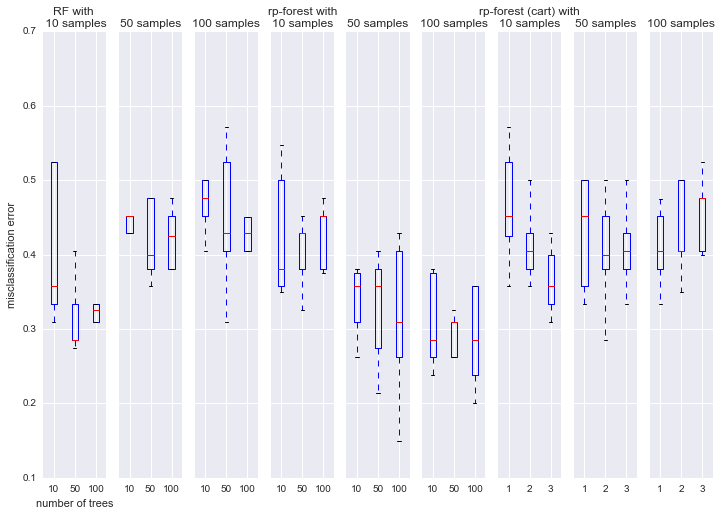

In [54]:
pylab.rcParams['figure.figsize'] = (12.0, 8.0)
fig = plt.figure()
f, (ax1, ax2, ax3, ax4,ax5,ax6, ax7,ax8,ax9) = plt.subplots(1, 9, sharey=True)

data = np.array(scores_fc1).T
data1 = data[:,[0,3,6]]
ax1.boxplot(data1)
ax1.set_xlabel("number of trees")
ax1.set_ylabel("misclassification error")
ax1.set_title("RF with \n 10 samples")
data2 = data[:,[1,4,7]]
ax2.boxplot(data2)
ax2.set_title("50 samples")
data3 = data[:,[2,5,8]]
ax3.boxplot(data3)
ax3.set_title("100 samples")

data_rp = np.array(scores_fc2).T
data1_rp = data_rp[:,[0,3,6]]
ax4.boxplot(data1_rp)
ax4.set_title("rp-forest with\n10 samples")
data2_rp = data_rp[:,[1,4,7]]
ax5.boxplot(data2_rp)
ax5.set_title("50 samples")
data3_rp = data_rp[:,[2,5,8]]
ax6.boxplot(data3_rp)
ax6.set_title("100 samples")

data_rpc = np.array(scores_fc3).T
data1_rpc = data_rpc[:,[0,3,6]]
ax7.boxplot(data1_rpc)
ax7.set_title("rp-forest (cart) with\n10 samples")
data2_rpc = data_rpc[:,[1,4,7]]
ax8.boxplot(data2_rpc)
ax8.set_title("50 samples")
data3_rpc = data_rpc[:,[2,5,8]]
ax9.boxplot(data3_rpc)
ax9.set_title("100 samples")
##
plt.sca(ax1)
plt.xticks([1, 2, 3], [10, 50, 100])
plt.sca(ax2)
plt.xticks([1, 2, 3], [10, 50, 100])
plt.sca(ax3)
plt.xticks([1, 2, 3], [10, 50, 100])
plt.sca(ax4)
plt.xticks([1, 2, 3], [10, 50, 100])
plt.sca(ax5)
plt.xticks([1, 2, 3], [10, 50, 100])
plt.sca(ax6)
plt.xticks([1, 2, 3], [10, 50, 100])
plt.show()


In [32]:
params_fc1

[[10, 10],
 [10, 50],
 [10, 100],
 [50, 10],
 [50, 50],
 [50, 100],
 [100, 10],
 [100, 50],
 [100, 100]]

## Dataset II - High-dim mixture of Gaussians 

In [ ]:
def sample_highdim_gauss(data_dim, intrinsic_dim, n_samples, n_components=2):
    

## Dataset III - Dictionary learning model

In [ ]:
def sample_dict_learn(dictDim, numDict, sparsity, srange, num_samples):
    """
    Input
        -dictDim
        -numDict
        -sparsity
        -srange
        -num_samples
        
    Output
        -Y: dictDim by num_samples
    """
    ## we use independent Gaussian as our dictionary
    A = np.empty([dictDim, numDict])
    for i in range(dictDim):
        for j in range(numDict):
            A[i,j] = np.random.normal() #default mean 0, var 1
    
    X = np.zeros([numDict, num_samples])
    for s in range(num_samples):
        #randomly sample indices
        ind = np.random.choice(numDict, sparsity, replace = False) #sample without replacement
        val = np.random.uniform(low=srange[0], high=srange[1], size=sparsity)
        sign = np.ones(sparsity)
        #negate = np.random.choice(sparsity, sparsity/2, replace = False)
        #sign[negate] = -1
        
        #X[ind, s] = np.multiply(val, sign)
        X[ind, s] = val
        #print X[:,s]
    
    Y = np.dot(A,X)
    
    return A,X,Y


##test
A,X,Y = sample_DL_model(5, 5, 2, [2,10], 10)


## Dataset original - Sonar

In [40]:
# pickle or get pickled data with desired dataname
def maybe_pickle(dataname, data = None, force = False, verbose = True):
    """
    Process and pickle a dataset if not present
    """
    filename = dataname + '.pickle'
    if force or not os.path.exists(filename):
        # pickle the dataset
        print('Pickling data to file %s' % filename)
        try:
            with open(filename, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save to', filename, ':', e) 
    else:
        print('%s already present - Skipping pickling.' % filename)
        with open(filename, 'rb') as f:
            data = pickle.load(f)

    return data

####
data_dict=maybe_pickle('sonar.all_data') 

sonar.all_data.pickle already present - Skipping pickling.


In [41]:
data = data_dict['data']
labels = data_dict['labels']
data_tr = data[:104,:]
labels_tr = labels[:104]
data_tt = data[104:,:]
labels_tt = labels[104:]
print("number of one's in labels are %d" %labels.sum())
print("number of one's in training labels are %d" %labels_tr.sum())

number of one's in labels are 111
number of one's in training labels are 58


In [42]:
mtry = 10
max_height = 8
#n_trees_list = [1,10,100,500]
#n_samples_list = [10, 50, 100, 200]

scores = list()
kwargs = dict()
#kwargs['n_estimators'] = n_trees
kwargs['max_depth'] = max_height
kwargs['max_features'] = mtry
scores.append(cross_valid_eval(data_tr, labels_tr, 5, zero_one_loss, DecisionTreeClassifier, 
                                       sklearn=True, **kwargs))

Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold


In [47]:
mtry = 10
max_height = 8
n_trees_list = [1,10,100,500]
#n_samples_list = [10, 50, 100, 200]

scores_fc1 = list()
params_fc1 = list()
kwargs = dict()
for n_trees in n_trees_list:
    kwargs['n_estimators'] = n_trees
    kwargs['max_depth'] = max_height
    kwargs['max_features'] = mtry
    scores_fc1.append(cross_valid_eval(data_tr, labels_tr, 5, zero_one_loss, RandomForestClassifier, 
                                       sklearn=True, **kwargs))
    params_fc1.append(n_trees)
    #estimator = RandomForestClassifier(n_estimators=n_trees, max_features=mtry, max_depth=max_height)
    #estimator.fit(data_tr, labels_tr)
    #estimator.predict()

Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold
Evaluating the 1-th fold
Evaluating the 2-th fold
Evaluating the 3-th fold
Evaluating the 4-th fold
Evaluating the 5-th fold


In [48]:
display(np.mean(scores_fc1,axis=1))


array([ 0.26095238,  0.24095238,  0.18238095,  0.22095238])

In [43]:
for i in range(len(scores)):
    print(scores[i][0])

[0.19047619047619047, 0.3333333333333333, 0.19047619047619047, 0.23809523809523808, 0.35]
